In [14]:
import os
os.chdir('..')
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import glob
import config
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
from utils.geotif_io import readTiff
from utils.transform_xy import coor2coor


In [2]:
paths_truth = glob.glob(config.root_proj+'/data/dset/s1_truth/*.tif')
paths_truth = sorted(paths_truth)
names_truth = [os.path.basename(path) for path in paths_truth]
scene_id = [name[0:7] for name in names_truth]
scene_id[0]


'scene01'

In [38]:
## extract scene footprint of the dset.
fprint_wgs84 = []
center_wgs84 = []
for path in paths_truth:
    img, img_info = readTiff(path)
    lon_1, lon_2, lat_1, lat_2 = img_info['geoextent']
    lon = [lon_1, lon_2, lon_2, lon_1, lon_1]
    lat = [lat_1, lat_1, lat_2, lat_2, lat_1]
    lon_wgs84, lat_wgs84 = coor2coor(srs_from=img_info['geosrs'], srs_to=4326, x=lon, y=lat)
    fprint = Polygon(zip(lon_wgs84, lat_wgs84))
    fprint_wgs84.append(fprint)

print('number of footprints:',len(fprint_wgs84))


number of footprints: 22


In [78]:
# writh the data information to geopandas
dic = {'scene_id': scene_id}
df = pd.DataFrame(dic)
geodf = gpd.GeoDataFrame(df, geometry=fprint_wgs84, crs=4326)
# geodf.to_file(config.root_proj+'/data/dset/loc_vec/scene_footprint.shp')
geodf.head()

,scene_id,geometry
0,scene01,"POLYGON ((82.25568 33.84709, 82.64803 33.84246..."
1,scene02,"POLYGON ((97.93004 34.61704, 98.35243 34.62001..."
2,scene03,"POLYGON ((90.61015 28.83351, 91.01593 28.84009..."
3,scene04,"POLYGON ((86.67000 35.47958, 87.09000 35.48000..."
4,scene05,"POLYGON ((89.78144 33.82872, 90.12918 33.82038..."


In [40]:
path_dset_fprint =  config.root_proj + '/data/dset/loc_vec/scene_footprint.shp'
path_tibet_vec =  config.root_proj + '/data/tibet/tibet-plateau-boundary/TPBoundary_HF/TPBoundary_HF_wgs84.shp'


In [71]:
## obtain centers coordinates of the scenes in dataset
geodf_fp = gpd.read_file(path_dset_fprint)
coord_centers = []
for fprint in geodf_fp['geometry']:
    coord_centers += list(fprint.centroid.coords)
coord_centers = np.array(coord_centers)
coord_centers.shape


(22, 2)

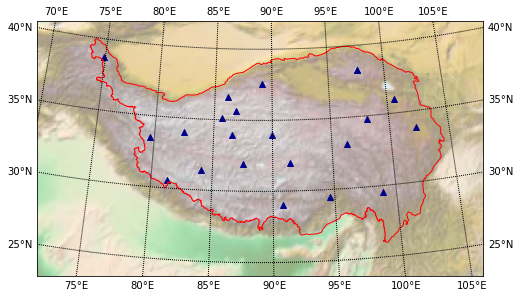

In [77]:
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution=None,
            width=3.5E6, height=2E6, 
            lat_0=33, lon_0=88.96)

m.etopo(scale=0.5, alpha=0.5)
# m.shadedrelief(scale=0.5)

parallels = np.arange(0.,90, 5.)  # lat
m.drawparallels(parallels,labels=[True,True,False,False])   # labels=[left,right,top,bottom]
meridians = np.arange(0.,360.,5.)  # lon
m.drawmeridians(meridians,labels=[False,False,True,True])

m.readshapefile(path_tibet_vec[:-4],'tibet_region', linewidth=1, color='r');
# Map scene point on the basemap
x, y = m(coord_centers[:,0], coord_centers[:,1])
plt.scatter(x, y, 35, color='darkblue', marker='^')
# Map scene boundary on the basemap
# m.readshapefile(path_dset_fprint[:-4],'scene_boudary', linewidth=1, color='blue');
